# Tritium removal from bubble sparging

In this notebook, we derive some expressions for estimating the tritium removal effiency from bubble sparging.
We also investigate the influence of parameters such as temperature, bubble radius...

## Analytical derivations

As FLiBe behaves according to Henry's law of solubility, on can express the concentration in the FLiBe at the surface of the bubble $c_\mathrm{FLiBe}$ as the product of the tritium partial pressure in the bubble $P$ and the FLiBe solubility $K_H$.

In [1]:
import sympy as sp
from sympy.abc import t

P = sp.Function("P")(t)
c_flibe = sp.Function(r"c_\mathrm{FLiBe}")(t)
henry_sol = sp.Symbol("K_H")

# Henry's law at the surface of the bubble

henry_law = sp.Eq(c_flibe, henry_sol * P)
henry_law


Eq(c_\mathrm{FLiBe}(t), K_H*P(t))

Let's apply the perfect gas law:
- $V$: volume of the bubble
- $R$: perfect gas constant
- $n$: quantity of tritium in the bubble
- $T$: temperature

In [2]:
n = sp.Function("n")(t)
V = sp.Symbol("V")
R = sp.Symbol("R")
T = sp.Symbol("T")

# perfect gas law in bubble
perfect_gas = sp.Eq(P * V, n * R * T)
perfect_gas


Eq(V*P(t), R*T*n(t))

By expressing substituting the pressure, one can obtain:

In [3]:
c_flibe_expr = henry_law.subs(P, sp.solve(perfect_gas, P)[0])
c_flibe_expr


Eq(c_\mathrm{FLiBe}(t), K_H*R*T*n(t)/V)

The time derivative of $c_\mathrm{FLiBe}$ is therefore:

In [4]:
time_diff_c_flibe = sp.Eq(
    sp.Derivative(c_flibe_expr.lhs, t), sp.Derivative(c_flibe_expr.rhs, t)
).simplify()
time_diff_c_flibe


Eq(Derivative(c_\mathrm{FLiBe}(t), t), K_H*R*T*Derivative(n(t), t)/V)

The increase rate of tritium quantity $n$ in the bubble can be expressed by solving the steady-state diffusion equation in spherical coordinates and integrating the inward particle flux at the surface of the bubble.

The time derivative of $n$ can therefore be expressed as a function of:
- $D$: the FLiBe diffusivity
- $S$: the surface area of the bubble
- $r$: the bubble radius
- $c_\infty$: the tritium concentration "far away"

In [5]:
diff = sp.Symbol("D")
S = sp.Symbol("S")
r = sp.Symbol("r")
c_inf = sp.Symbol(r"c_\infty")

n_dot_expr = sp.Eq(sp.Derivative(n, t), diff * S / r * (c_inf - c_flibe))
n_dot_expr


Eq(Derivative(n(t), t), D*S*(c_\infty - c_\mathrm{FLiBe}(t))/r)

By replacing $dn/dt$ in the expression of $dc_\mathrm{FLiBe}/dt$:

In [6]:
time_diff_c_flibe = time_diff_c_flibe.subs(sp.Derivative(n, t), n_dot_expr.rhs)
time_diff_c_flibe


Eq(Derivative(c_\mathrm{FLiBe}(t), t), D*K_H*R*S*T*(c_\infty - c_\mathrm{FLiBe}(t))/(V*r))

Since both the surface area and the volume of a sphere are function of the radius $r$:

In [7]:
sphere_volume = sp.Rational(4) / sp.Rational(3) * sp.pi * r**3
sphere_surface = sp.Rational(4) * sp.pi * r**2

time_diff_c_flibe = time_diff_c_flibe.subs({V: sphere_volume, S: sphere_surface})
time_diff_c_flibe


Eq(Derivative(c_\mathrm{FLiBe}(t), t), 3*D*K_H*R*T*(c_\infty - c_\mathrm{FLiBe}(t))/r**2)

We define the characteristic time $\tau$ as:

In [8]:
charac_time = sp.Symbol(r"\tau")
tau_def = sp.Eq(charac_time, 1 / (3 * diff * henry_sol * R * T / r**2))
tau_def


Eq(\tau, r**2/(3*D*K_H*R*T))

Substituting by $\tau$ in the expression of $dc_\mathrm{FLiBe}/dt$ gives:

In [9]:
time_diff_c_flibe = time_diff_c_flibe.subs(
    3 * diff * henry_sol * R * T, sp.solve(tau_def, 3 * diff * henry_sol * R * T)[0]
)
time_diff_c_flibe


Eq(Derivative(c_\mathrm{FLiBe}(t), t), (c_\infty - c_\mathrm{FLiBe}(t))/\tau)

The temporal evolution of $c_\mathrm{FLiBe}$ is obtained by solving the ODE:

In [10]:
c_flibe_time_expr = sp.dsolve(time_diff_c_flibe, c_flibe, ics={c_flibe.subs(t, 0): 0})
c_flibe_time_expr


Eq(c_\mathrm{FLiBe}(t), c_\infty - c_\infty*exp(-t/\tau))

Factorising by $c_\infty$:

In [11]:
c_flibe_time_expr = sp.Eq(c_flibe_time_expr.lhs, c_flibe_time_expr.rhs.collect(c_inf))
c_flibe_time_expr


Eq(c_\mathrm{FLiBe}(t), c_\infty*(1 - exp(-t/\tau)))

Here, when $t/\tau$ increases, $c_\mathrm{FLiBe} \approx c_\infty$.

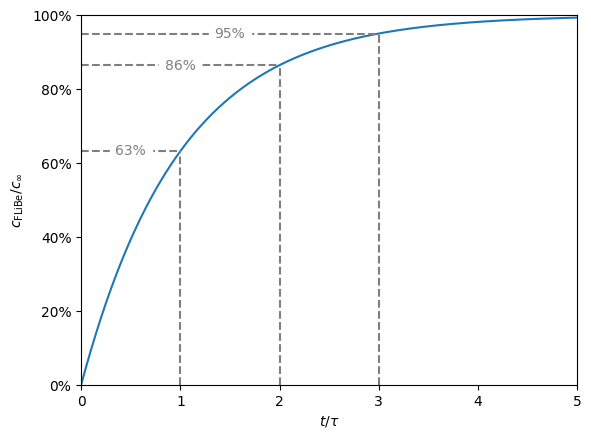

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np


# transform sympy expression in a python function
args = (charac_time, c_inf, t)
compute_c_flibe = sp.lambdify(
    args,
    c_flibe_time_expr.rhs,
)

# plot temporal evolution of concentration
tau = 2
times = np.linspace(0, 5 * tau, num=500)

concentrations = compute_c_flibe(tau, 1, times)

plt.plot(times / tau, concentrations, color="tab:blue")

# add indication lines
line_args = {"linestyle": "dashed", "color": "tab:grey"}
for t_over_tau in [1, 2, 3]:
    height = compute_c_flibe(tau, 1, t_over_tau * tau)
    plt.vlines(x=[t_over_tau], ymin=0, ymax=height, **line_args)
    plt.hlines(y=[height], xmin=0, xmax=t_over_tau, **line_args)
    plt.annotate(
        f"{height:.0%}",
        (t_over_tau / 2, height),
        ha="center",
        va="center",
        backgroundcolor="w",
        color="tab:grey",
    )

plt.xlabel(r"$t/\tau$")
plt.ylabel("$c_\mathrm{FLiBe}/c_\infty$")
plt.ylim(0, 1)
plt.xlim(0, 5)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


## Adding real numbers

We now investigate the behaviour of the characteristic time $\tau$ with LIBRA relevant parameters.

Let's first evaluate the FLiBe's diffusivity and solubility properties. We will rely on the [HTM](https://github.com/RemDelaporteMathurin/h-transport-materials) library.

In [13]:
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()


We consider the mean value of tritium diffusivities in FLiBe present in the HTM database:

In [14]:
diffusivities = htm.diffusivities.filter(material="flibe", isotope="t")
D_0, E_D = diffusivities.mean()
mean_diff = htm.Diffusivity(
    D_0 * diffusivities[0].units,
    E_D * ureg.eV * ureg.particle**-1,
)
print(mean_diff)



        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 5.729948226646946e-07 m ** 2 / s
        Activation energy: 0.37535747466879604 eV
        


Same for solubility:

In [15]:
solubilities = htm.solubilities.filter(material="flibe", isotope="t")
S_0, E_S = solubilities.mean()
mean_sol = htm.Solubility(
    "m-3 Pa-1",
    S_0=S_0 * solubilities[0].units,
    E_S=E_S * ureg.eV * ureg.particle**-1,
)
print(mean_sol)



        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 4.757491200400059e+22 particle / Pa / m ** 3
        Activation energy: 0.3627494379691766 eV
        


We can now evaluate the characteristic time $\tau$ as a function of the temperature $T$ and radius $r$.

In [16]:
import pint

# convert sympy expression to python function
args = (diff, henry_sol, R, T, r)
eval_function = sp.lambdify(
    args,
    tau_def.rhs,
)

GAS_CONSTANT = 8.314 * ureg.J * ureg.mol**-1 * ureg.K**-1


def compute_characteristic_time(T: pint.Quantity, radius: pint.Quantity):
    """Compute the bubble concentration characteristic time

    Args:
        T (pint.Quantity): the temperature
        radius (pint.Quantity): the bubble radius

    Returns:
        pint.Quantity: the characteristic time in s
    """
    K_H = mean_sol.value(T.to(ureg.K).magnitude) * mean_sol.units
    D = mean_diff.value(T.to(ureg.K).magnitude) * mean_diff.units
    time = eval_function(D, K_H, GAS_CONSTANT, T.to(ureg.K), radius)
    return time.to(ureg.s)


C:\Users\remidm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


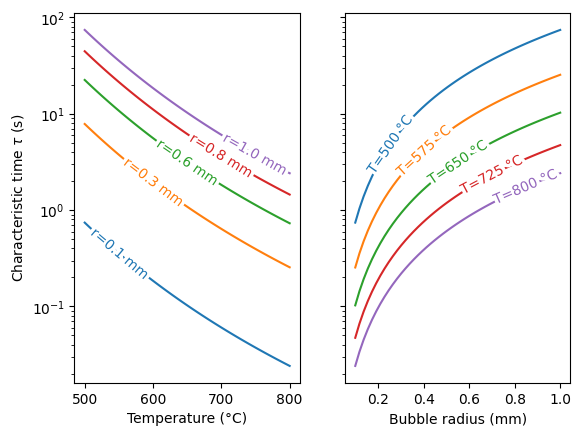

In [17]:
from labellines import labelLines

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)


# vary temperature
plt.sca(axs[0])
T_range = np.linspace(500, 800) * ureg.degC
radii = np.linspace(0.1, 1, num=5) * ureg.mm

for radius in radii:
    plt.plot(
        T_range,
        compute_characteristic_time(T_range, radius).to(ureg.s),
        label=f"r={radius:~.1f}",
    )

# vary radius
plt.sca(axs[1])

radius_range = np.linspace(0.1, 1) * ureg.mm
temperatures = np.linspace(500, 800, num=5) * ureg.degC

for T in temperatures:
    plt.plot(
        radius_range,
        compute_characteristic_time(T, radius_range).to(ureg.s),
        label=f"T={T:~.0f}",
    )

axs[0].set_ylabel(r"Characteristic time $\tau$ (s)")
axs[0].set_xlabel(f"Temperature ({T_range.units: ~P})")
axs[1].set_xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.yscale("log")

labelLines(axs[0].get_lines(), zorder=2.5)
labelLines(axs[1].get_lines(), zorder=2.5)
plt.show()


As expected, increasing the radius $r$ increases the characteristic time $\tau$ and increasing the temperature $T$ reducing the characteristic time.
This can also be observed on a 2D map:

C:\Users\remidm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


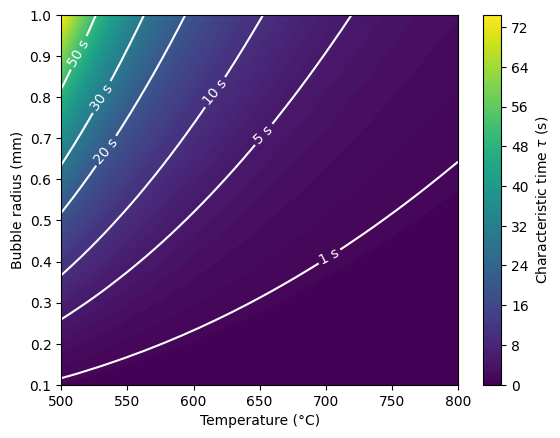

In [18]:
from matplotlib import ticker, cm, colors

XX, YY = np.meshgrid(T_range, radius_range)
ZZ = compute_characteristic_time(XX, YY)
cs = plt.contourf(XX, YY, ZZ, levels=100)
cs2 = plt.contour(
    XX,
    YY,
    ZZ,
    levels=[1, 5, 10, 20, 30, 50],
    colors="white",
)


def fmt(x):
    return f"{x:.0f} {ZZ.units:~P}"


plt.clabel(cs2, cs2.levels, inline=True, fontsize=10, fmt=fmt)

plt.xlabel(f"Temperature ({T_range.units: ~P})")
plt.ylabel(f"Bubble radius ({radius_range.units: ~P})")
cbar = fig.colorbar(cs, label=r"Characteristic time $\tau$ (s)")


How does that compare with the bubble lifetime in LIBRA?

The bubble rise velocity $u_b$ can be calculated using the [Rollbusch correlation](https://doi.org/10.1016/j.ces.2014.11.061) (modified Mendelson correlation):

In [19]:
u_b_rollbusch = sp.Symbol("u_{b, \mathrm{Rollbusch}}")

sigma = sp.Symbol(r"\sigma")  # surface tension coefficient
rho_L = sp.Symbol(r"\rho_L")  # density liquid
d_b = sp.Symbol("d_b")  # bubble diameter
g = sp.Symbol("g")  # gravity constant
rho_G = sp.Symbol(r"\rho_G")  # density gas

rollbusch_corr = sp.Eq(u_b_rollbusch, sp.sqrt(2*sigma/(rho_L*d_b) + ((rho_L - rho_G)/rho_L) * (g*d_b/2)))
rollbusch_corr

Eq(u_{b, \mathrm{Rollbusch}}, sqrt(2*\sigma/(\rho_L*d_b) + d_b*g*(-\rho_G + \rho_L)/(2*\rho_L)))

In [20]:
u_b_stokes = sp.Symbol("u_{b, \mathrm{Stokes}}")
mu_L = sp.Symbol("\mu_\mathrm{L}")
stokes_correlation = sp.Eq(u_b_stokes, 1/sp.Rational(18) * (rho_L - rho_G)/mu_L * g * d_b**2)
stokes_correlation.simplify()

Eq(u_{b, \mathrm{Stokes}}, d_b**2*g*(-\rho_G + \rho_L)/(18*\mu_\mathrm{L}))

[Jamialialahmadi et al](https://doi.org/10.1016/j.expthermflusci.2018.12.018) defined the rise velocity correlation suitable at high temperatures:

In [21]:
u_b = sp.Symbol("u_b")

jamialialahmadi_corr = sp.Eq(u_b, u_b_stokes*u_b_rollbusch/sp.sqrt(u_b_stokes**2 + u_b_rollbusch**2))
jamialialahmadi_corr

Eq(u_b, u_{b, \mathrm{Rollbusch}}*u_{b, \mathrm{Stokes}}/sqrt(u_{b, \mathrm{Rollbusch}}**2 + u_{b, \mathrm{Stokes}}**2))

In [22]:
jamialialahmadi_corr = jamialialahmadi_corr.subs(u_b_stokes, stokes_correlation.rhs).subs(u_b_rollbusch, rollbusch_corr.rhs)
jamialialahmadi_corr = jamialialahmadi_corr.subs(d_b, 2*r)
jamialialahmadi_corr

Eq(u_b, 4*g*r**2*(-\rho_G/18 + \rho_L/18)*sqrt(\sigma/(\rho_L*r) + g*r*(-\rho_G + \rho_L)/\rho_L)/(\mu_\mathrm{L}*sqrt(\sigma/(\rho_L*r) + g*r*(-\rho_G + \rho_L)/\rho_L + 16*g**2*r**4*(-\rho_G/18 + \rho_L/18)**2/\mu_\mathrm{L}**2)))

Sources:
- FLiBe's density (OoM): https://inldigitallibrary.inl.gov/sites/sti/sti/4502650.pdf 
- FLiBe's dynamic visc (OoM): https://inldigitallibrary.inl.gov/sites/sti/sti/4502650.pdf 
- helium's density: https://www.lenntech.com/periodic/elements/he.htm
- surface tension: https://inldigitallibrary.inl.gov/sites/sti/sti/4502650.pdf

Text(0, 0.5, 'Bubble rise velocity (cm/s)')

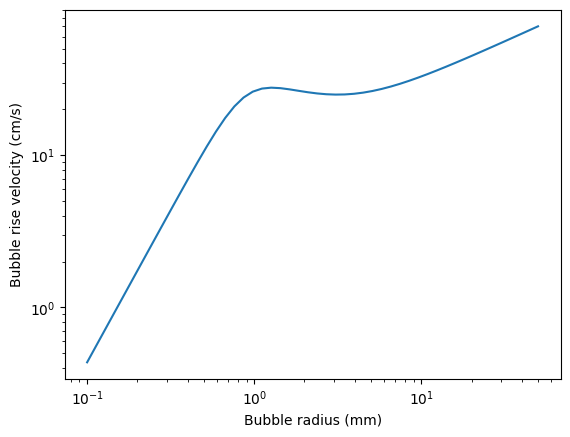

In [23]:
args = (g, sigma, mu_L, rho_L, rho_G, r)
compute_rise_vel = sp.lambdify(args, jamialialahmadi_corr.rhs)

gravity_constant = 9.807 * ureg.m * ureg.s**-2
flibe_density = 2000 * ureg.kg * ureg.m**-3
gas_density = 0.178e-3 * ureg.g * ureg.cm**-3
surface_tension = 0.2 * ureg.N * ureg.m**-1
viscosity = 0.01 * ureg.Pa * ureg.s

radius_range = np.geomspace(0.1, 50) * ureg.mm

rise_vel = compute_rise_vel(
    gravity_constant,
    surface_tension,
    viscosity,
    flibe_density,
    gas_density,
    radius_range,
).to(ureg.cm * ureg.s**-1)
plt.loglog(radius_range, rise_vel)

plt.xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.ylabel(f"Bubble rise velocity ({rise_vel.units: ~P})")

(0.0, 240.8518243214795)

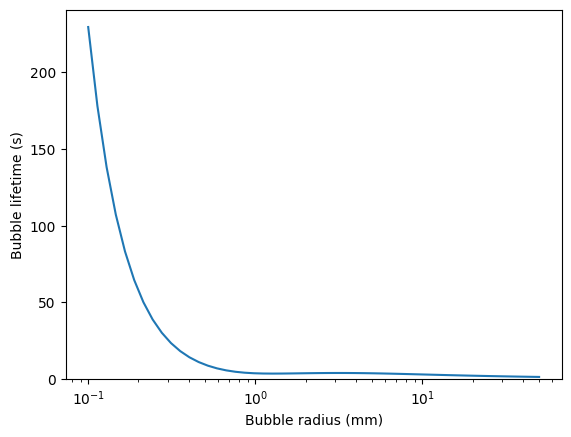

In [24]:
height_libra_tank = 1 * ureg.m
bubble_lifetime = (height_libra_tank/rise_vel).to(ureg.s)

plt.plot(radius_range, bubble_lifetime)
plt.xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.ylabel(f"Bubble lifetime ({bubble_lifetime.units: ~P})")
plt.xscale("log")
plt.ylim(bottom=0)

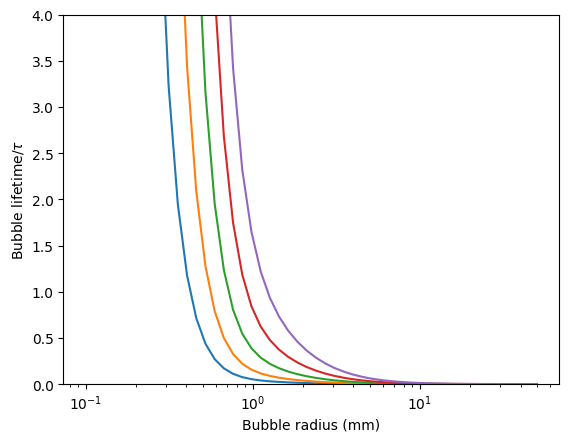

In [25]:
temperatures = np.linspace(500, 800, num=5) * ureg.degC
for T in temperatures:
    plt.plot(radius_range, bubble_lifetime/compute_characteristic_time(T, radius_range))
plt.xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.ylabel(r"Bubble lifetime/$\tau$")
plt.ylim(0, 4)
plt.xscale("log")

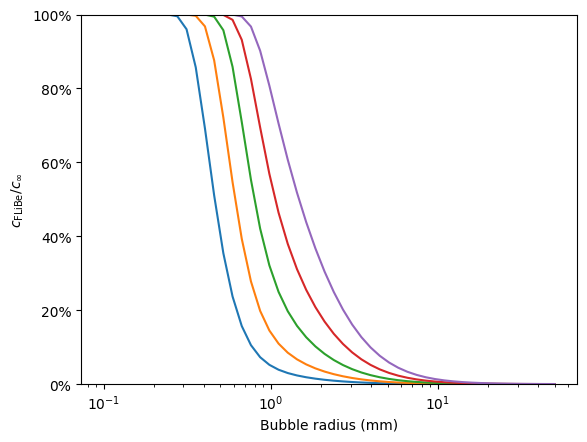

In [26]:
for T in temperatures:
    tau = compute_characteristic_time(T, radius_range)
    concentrations = compute_c_flibe(tau, 1, bubble_lifetime)
    plt.plot(radius_range, concentrations)
plt.xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.ylabel(r"$c_\mathrm{FLiBe}/c_\infty$")
plt.ylim(0, 1)
plt.xscale("log")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


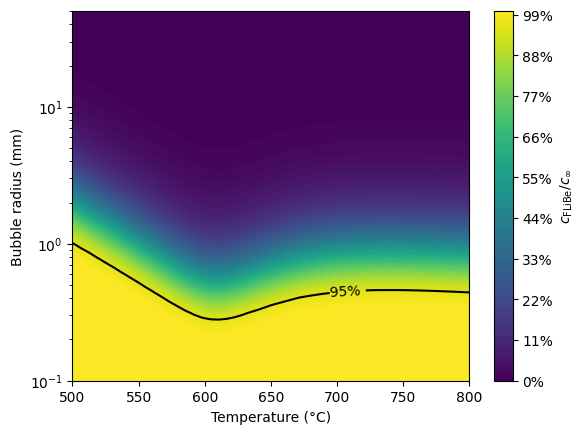

In [41]:
TT, rr = np.meshgrid(T_range, radius_range)
tautau = compute_characteristic_time(TT, rr)
rise_vel = compute_rise_vel(
    gravity_constant,
    surface_tension,
    viscosity,
    flibe_density,
    gas_density,
    rr,
)
bubble_lifetime_ = height_libra_tank/rise_vel
concentrations = compute_c_flibe(tautau, 1, bubble_lifetime)

cs = plt.contourf(TT, rr, concentrations, levels=100)
cs2 = plt.contour(
    TT,
    rr,
    concentrations,
    levels=[0.95],
    colors="black",
)

plt.yscale("log")
def fmt(x):
    return f"{x:.0%} {concentrations.units:~P}"


plt.clabel(cs2, cs2.levels, inline=True, fontsize=10, fmt=fmt)

plt.xlabel(f"Temperature ({T_range.units: ~P})")
plt.ylabel(f"Bubble radius ({radius_range.units: ~P})")
cbar = fig.colorbar(cs, label=r"$c_\mathrm{FLiBe}/c_\infty$", format=mtick.PercentFormatter(1.0))